In [1]:
import matplotlib.pyplot as plt
import cv2
import time
from navigation import NavigationSystem
from helpers import load_images_from_folder

%matplotlib inline

Semantic Segmentation using FCHardNet
Loading Object Detection
Segmentation and Detection Models loaded, Testing the models
Imgs tested
Planner


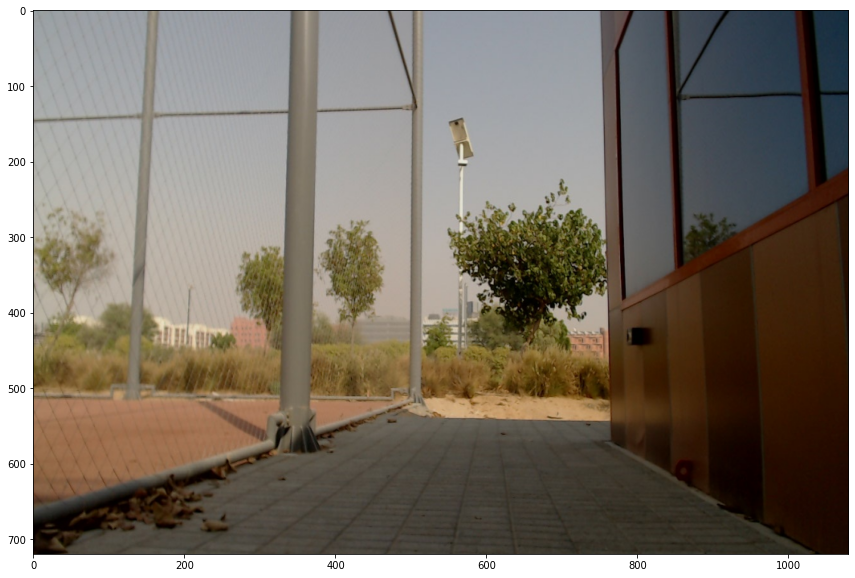

zeros
0.23586344718933105


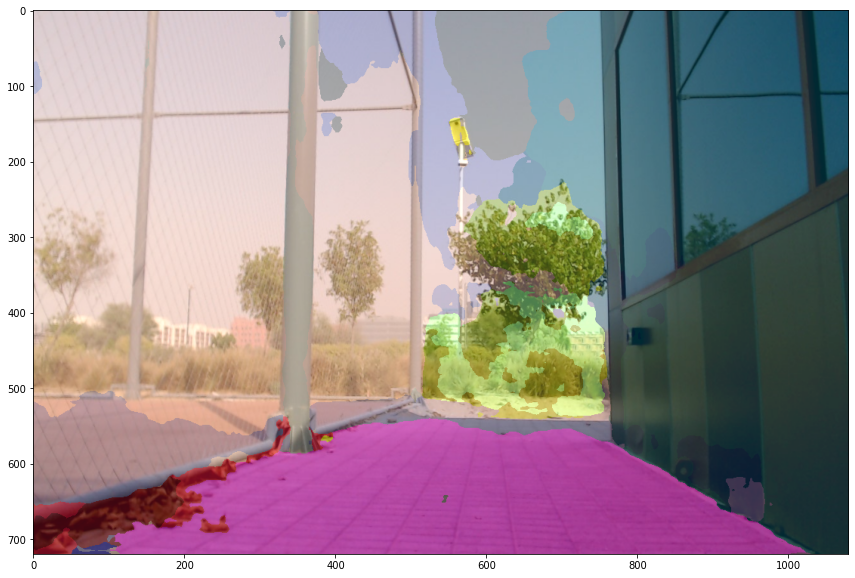

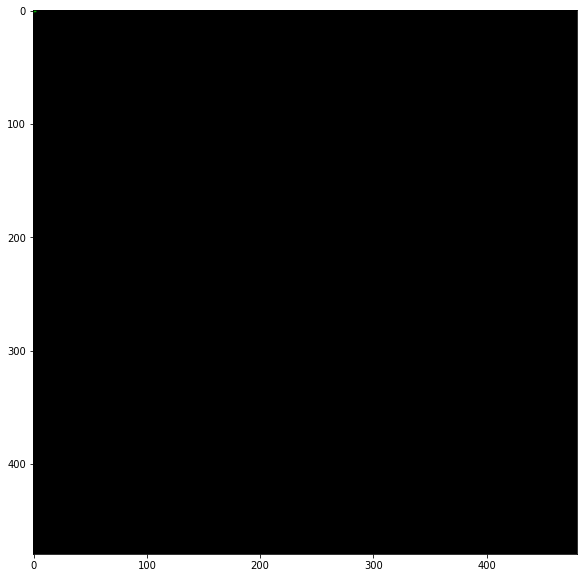

In [8]:
nav = NavigationSystem(False)
img = cv2.imread("./data/jackal_cam/left0191.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

dim = (1080, 720)
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2RGB))
plt.show()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
start = time.time()
path, result_img, result_birdview = nav.global_planner_step(img, None)
end = time.time()
print(end-start)
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(result_img)
plt.show()
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(result_birdview)
plt.show()

In [3]:
imgs, filenames = load_images_from_folder('./data/jackal_cam')
print('processing {} images'.format(len(imgs)))
i=0
start = time.time()

for img, filename in zip(imgs, filenames):
    print('===============File: {} ============'.format(filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
    path, result_img, result_birdview = nav.global_planner_step(img, None)
    
    h,w,_ = result_img.shape
    result_birdview = cv2.resize(result_birdview, (h,h), interpolation = cv2.INTER_AREA)
    concat = cv2.hconcat([result_img, result_birdview])
#     fig, ax = plt.subplots(figsize=(14, 7))
#     ax.imshow(concat)
#     plt.show()   
    concat = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite('./output/out2/{}'.format(filename), concat)
    i = i+1
end = time.time()
print('avg time: {}'.format((end-start)/len(imgs)))

processing 2597 images
===============File: left0279.jpg ============
zeros
===============File: left0488.jpg ============
zeros
===============File: left1726.jpg ============
zeros
===============File: left1392.jpg ============
zeros
===============File: left0580.jpg ============
zeros
===============File: left1061.jpg ============
zeros
===============File: left0198.jpg ============


/usr/src/app/dev_ws/src/vision/vision/costmap.py:96: RuntimeWarning: invalid value encountered in true_divide
  cost_obst/=np.amax(cost_obst)


zeros
===============File: left0207.jpg ============
zeros
===============File: left0863.jpg ============
zeros
===============File: left0353.jpg ============
zeros
===============File: left1622.jpg ============
zeros
===============File: left1466.jpg ============
zeros
===============File: left1781.jpg ============
zeros
===============File: left0538.jpg ============
zeros
===============File: left0393.jpg ============
zeros
===============File: left0822.jpg ============
zeros
===============File: left0662.jpg ============
zeros
===============File: left1969.jpg ============
zeros
===============File: left1157.jpg ============
zeros
===============File: left0048.jpg ============
zeros
===============File: left0852.jpg ============
zeros
===============File: left1170.jpg ============
zeros
===============File: left0716.jpg ============
zeros
===============File: left1295.jpg ============
zeros
===============File: left0571.jpg ============
zeros
===============File: left2438.jpg ======

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


zeros
===============File: left1845.jpg ============
zeros
===============File: left0698.jpg ============
zeros
===============File: left2158.jpg ============
zeros
===============File: left0667.jpg ============
zeros
===============File: left2567.jpg ============
zeros
===============File: left2504.jpg ============
left line not found, adding it
===============File: left2253.jpg ============
zeros
===============File: left1629.jpg ============
zeros
===============File: left1134.jpg ============
zeros
===============File: left1181.jpg ============
zeros
===============File: left2362.jpg ============
zeros
===============File: left0030.jpg ============
zeros
===============File: left0128.jpg ============
zeros
===============File: left1732.jpg ============
zeros
===============File: left0844.jpg ============
zeros
===============File: left1193.jpg ============
zeros
===============File: left1148.jpg ============
zeros
===============File: left1509.jpg ============
left line not found, 

In [5]:

import torch
torch.backends.cudnn.benchmark = True
import argparse
import os
import cv2
import sys
import numpy as np
from object_detection import ObjectDetector
from segmentation import SemanticSegmentation
from helpers import warped2scan, warp_driveable, get_driveable_mask,get_driveable_mask2
import math
from collections import deque
%matplotlib inline
FORWARD_WEIGHT = 3.0
CENTER_WEIGHT = 0.5
HEIGHT=480
WIDTH=480
OSCILLATIONS_DETECTION_LENGTH = 3
PIXEL_PER_METER_X = (WIDTH - 2*150)/3.0 #Horizontal distance between src points in the real world ( I assumed 3.0 meters)
PIXEL_PER_METER_Y = (HEIGHT - 20-55)/6.0 #Vertical distance between src points in the real world ( I assumed 6.0 meters)
HORIZ_ANGLE_THRESHOLD = 15*math.pi/180.0
AVG_SIDEWALK_WIDTH = round(3.9*PIXEL_PER_METER_X)


class PerceptionSystem(object):
    def __init__(self): 
        # Load Models
        segmentation_model_path = os.path.join('/usr/src/app/dev_ws/src/vision/vision', 'pretrained', 'hardnet70_cityscapes_model.pkl')
        self.seg_model_ = SemanticSegmentation(segmentation_model_path)
        self.object_detector_ = ObjectDetector()
        
        # Load perspective transforms
        mtxs = np.load('/usr/src/app/dev_ws/src/vision/vision/PerspectiveTransform.npz')
        self.M_ = mtxs['M']
        self.M_inv_ = mtxs['M_inv']
        
        # Test Detection Models
        print('Segmentation and Detection Models loaded, Testing the models')
        img = cv2.imread("./data/73.png")
        self.h_orig_, self.w_orig_,_ = img.shape
        _, _ = self.seg_model_.process_img_driveable(img,[self.h_orig_,self.w_orig_])
        _ = self.object_detector_.process_frame(img)
        self.im_hw_ = self.object_detector_.im_hw
        print('Imgs tested')
        
    def get_driveable(self, driveable_decoded):
        h,w,_ = driveable_decoded.shape
        # Warp driveable area
        warped = cv2.warpPerspective(driveable_decoded, self.M_, (480, 480), flags=cv2.INTER_LINEAR)
        # Calculate robot center
        original_center = np.array([[[w/2,h]]],dtype=np.float32)
        warped_center = cv2.perspectiveTransform(original_center, self.M_)[0][0]    
        driveable_contour_mask = get_driveable_mask2(warped, warped_center)
        return driveable_contour_mask
    
    def add_detections_birdview(self, preds, driveable_mask):
        h,w,_ = self.object_detector_.im_hw
        h_rate = self.h_orig_/h
        w_rate = self.w_orig_/w
        for pred in preds:
            if(pred[4] > self.object_detector_.conf_thres): # If prediction has a bigger confidence than the threshold
                x = w_rate*(pred[0]+pred[2])/2.0 # Ground middle point
                y = h_rate*pred[3]
                if(pred[5]==0): #person
                    wr = 20
                    hr = 20
                    color = 150
                else:
                    wr = 20
                    hr = 40
                    color = 150
                pos_orig = np.array([[[x,y]]],dtype=np.float32)
                warped_birdview = cv2.perspectiveTransform(pos_orig, self.M_)[0][0] # Transform middle ground point to birdview
                warped_birdview = np.uint16(warped_birdview)
                cv2.rectangle(driveable_mask, (warped_birdview[0] -int(wr/2), warped_birdview[1]-int(hr/2)), (warped_birdview[0] +int(wr/2), warped_birdview[1]+int(hr/2)), color, -1) 

        
    def process_frame(self,img):
        # Semantic Segmentation
        img_test = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_decoded, driveable_decoded = self.seg_model_.process_img_driveable(img_test,[self.h_orig_,self.w_orig_])
        
        # Get bird eye view with driveable area limits
        driveable_mask  = self.get_driveable(driveable_decoded)
        
        # Object Detection
        preds = self.object_detector_.process_frame(img)
        
        # Add Detections to birdview image
        driveable_mask_with_objects = driveable_mask.copy()
        self.add_detections_birdview(preds, driveable_mask_with_objects)
        
        return driveable_mask, preds, driveable_mask_with_objects
        
class CostMap(object):
    def __init__(self, M):
        # Temporary
        self.M_ = M
        self.h_orig_ = 720
        self.w_orig_ = 1080
        
    def calculate_costmap(self,driveable_mask, preds, driveable_mask_with_objects):
        
        
        # Find sidewalk edge lines and angle
        # h,w = driveable_mask.shape
        angle_avg, m_avg, b_avg = self.sidewalk_lines(driveable_mask, driveable_mask_with_objects) #driveable_mask_with_objects contains all objects and lines
        
        ## Find distance to center cost
        cost_center = self.center_cost(m_avg,b_avg)

        # Create obstacle cost map
        cost_obst = self.obstacle_cost(driveable_mask_with_objects)

        # Create inclination plane (forward cost)
        cost_forward = self.forward_cost(angle_avg)

        # Total cost
        cost_fcn = cost_obst+cost_forward*FORWARD_WEIGHT+cost_center*CENTER_WEIGHT
        
        return cost_fcn, cost_obst
        

    def gaus2d(self, x=0, y=0, mx=0, my=0, sx=1, sy=1):
        return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))
    
    def obstacle_cost(self, mask_with_objects, gaussian_shape = 150):
        x = np.linspace(-2, 2,gaussian_shape)
        y = np.linspace(-2, 2,gaussian_shape*2)
        x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
        z = self.gaus2d(x, y)
        z = np.float32(z)
        cost_obst = cv2.filter2D(mask_with_objects,-1,z)
        cost_obst/=np.amax(cost_obst)
        return cost_obst

    def forward_cost(self, angle):
        normal = np.array([math.tan(-angle),-1,HEIGHT])
        point = np.array([WIDTH/2, HEIGHT, 0])
        d = -np.sum(point*normal)# dot product
        xx, yy = np.meshgrid(range(WIDTH), range(HEIGHT))
        cost_forward = (-normal[0]*xx - normal[1]*yy - d)*1./normal[2]
        return cost_forward

    def center_cost(self, m,b):
        if m is not None:
            xx, yy = np.meshgrid(range(WIDTH), range(HEIGHT))
            cost_center = abs(-m*xx+yy-b)/math.sqrt(m**2+1)
        else:
            cost_center = np.zeros((WIDTH,HEIGHT))
        return cost_center/np.amax(cost_center)


   
    def sidewalk_lines(self, mask, mask_out):
        mask = np.uint8(mask)
        
        # Detect lines in driveable area mask
        lines = cv2.HoughLinesP(mask, 1, 1*np.pi / 180, 100, None, 150, 50)

        line_angles = []
        lines_left = []
        lines_right = []
        lines_found = True
        if(lines is not None):
            for line in lines:
                x2,y2,x1,y1 = line[0]
                # Calculate angle, checking which y-coordinate is higher
                if(y2<y1): angle = -math.atan2(y2-y1,x2-x1)-math.pi/2
                else: angle = -math.atan2(y1-y2,x1-x2)-math.pi/2
                line_angles.append(angle)
                    
                # Detect horizontal lines corresponding to the corners
                if(abs(angle-math.pi/2) < HORIZ_ANGLE_THRESHOLD):
                    cv2.line(mask_out,(round(x1),round(y1)),(round(x2),round(y2)),100,1)

                # Detect coordinate at the bottom of image
                if(x2 == x1): x2 += 1 # Avoid dividing by 0
                if(y2 == y1): y2 += 1 # Avoid dividing by 0
                    
                m = (y2-y1)/(x2-x1)
                b = y1-m*x1
                x3 = round((HEIGHT-b)/m)
                x1 = x3
                y1 = HEIGHT

                # Add lines to the left and right list
                if(x3<WIDTH/2):
                    lines_left.append([m,b,x2,y2,x1,y1])
                else:
                    lines_right.append([m,b,x2,y2,x1,y1])
    #         print('lines_left: {}'.format(np.array(lines_left)))
    #         print('lines_right: {}'.format(np.array(lines_right)))
            lines_left = np.array(lines_left)
            lines_right = np.array(lines_right)

            # Find average line left and right
            if(len(lines_left)>0):
                m_avg_left = np.average(lines_left[:,0])
                b_avg_left = np.average(lines_left[:,1])
                y1_left = np.amin(lines_left[:,3])
                x1_left = (y1_left - b_avg_left) / m_avg_left
                x2_left = (HEIGHT-b_avg_left) / m_avg_left
                if x2_left > 0 and x2_left < WIDTH:
                    y2_left = HEIGHT
                else:
                    x2_left = 0
                    y2_left = b_avg_left
                    
                if (len(lines_right) > 0): # both lines are found
                    m_avg_right = np.average(lines_right[:,0])
                    b_avg_right = np.average(lines_right[:,1])
                    y1_right = np.amin(lines_right[:,3])
                    x1_right = (y1_right - b_avg_right) / m_avg_right
                    x2_right = (HEIGHT-b_avg_right) / m_avg_right
                    if x2_right > 0 and x2_left < WIDTH:
                        y2_right = HEIGHT
                    else:
                        x2_right = 0
                        y2_right = b_avg_right
                else:
                    print('right line not found, adding it')
                    m_avg_right = m_avg_left  
                    b_avg_right = AVG_SIDEWALK_WIDTH*math.sqrt(m_avg_right**2+1)+b_avg_left
                    if((b_avg_right - b_avg_left) < 0):
                        b_avg_right = -AVG_SIDEWALK_WIDTH*math.sqrt(m_avg_right**2+1)+b_avg_left
                    y1_right = y1_left
                    x1_right = (y1_right - b_avg_right) / m_avg_right
                    y2_right = y2_left
                    x2_right = (y2_right - b_avg_right) / m_avg_right
            else:
                if (len(lines_right) > 0): # only right line found
                        
                    m_avg_right = np.average(lines_right[:,0])
                    b_avg_right = np.average(lines_right[:,1])
                    y1_right = np.amin(lines_right[:,3])
                    x1_right = (y1_right - b_avg_right) / m_avg_right
                    x2_right = (HEIGHT-b_avg_right) / m_avg_right
                    if x2_right > 0 and x2_right < WIDTH:
                        y2_right = HEIGHT
                    else:
                        x2_right = 0
                        y2_right = b_avg_right
                    m_avg_left = m_avg_right  
                    b_avg_left = -AVG_SIDEWALK_WIDTH*math.sqrt(m_avg_left**2+1)+b_avg_right
                    if((b_avg_left - b_avg_right) < 0):
        #                 print("si")
                        b_avg_left = AVG_SIDEWALK_WIDTH*math.sqrt(m_avg_right**2+1)+b_avg_right
                    y1_left = y1_right
                    x1_left = (y1_left - b_avg_left) / m_avg_left
                    y2_left = y2_right
                    x2_left = (y2_left - b_avg_left) / m_avg_left
                else:
                    angle_avg = 0
                    lines_found = False
        else:
            lines_found = False
        angle_avg = np.average(line_angles)

        if(lines_found):
    #         print([x1_right, y1_right, x2_right, y2_right])
    #         print([x1_left, y1_left, x2_left, y2_left])
            angle_left = -math.atan2(y2_left-y1_left,x2_left-x1_left)-math.pi/2
            angle_right = -math.atan2(y2_right-y1_right,x2_right-x1_right)-math.pi/2

            cv2.line(mask_out,(round(x1_left),round(y1_left)),(round(x2_left),round(y2_left)),200,3)
            cv2.line(mask_out,(round(x1_right),round(y1_right)),(round(x2_right),round(y2_right)),200,3)
            # Calculate middle line
            angle_avg = (angle_left + angle_right) / 2.0
            m_avg = math.tan(-angle_avg+math.pi/2.0)
            x_center = ( x2_left + x2_right ) / 2.0
            b_avg = HEIGHT - m_avg*x_center
        else:
            m_avg = None
            b_avg = None
        return angle_avg, m_avg, b_avg
                          

class PotentialFieldPlanner(object):
                          
    def __init__(self, M_inv):
        self.M_inv_ = M_inv
        print("Planner")
                         
    def get_motion_model(self):
        # dx, dy
        motion = [
    #               [1, 0], #right
    #               [0, 2], #back
    #               [-1, 0], #left
                  [0, -4], # front
                  [-1, -4],#front-left
                  [-2, -4],#front-left
                  [-3, -4],#front-left
                  [-4, -4],#front-left
    #               [-1, 2], # back-left
                  [1, -4], #front-right
                  [2, -4], #front-right
                  [3, -4], #front-right
                  [4, -4], #front-right
    #               [1, 1]  #back-right
                  ]
        return motion

    def oscillations_detection(self,previous_ids, ix, iy):
        previous_ids.append((ix, iy))
        if (len(previous_ids) > OSCILLATIONS_DETECTION_LENGTH):
            previous_ids.popleft()
        # check if contains any duplicates by copying into a set
        previous_ids_set = set()
        for index in previous_ids:
            if index in previous_ids_set:
                return True
            else:
                previous_ids_set.add(index)
        return False

    def calculate_path(self,pmap):
        output = pmap.copy()*0
        motion = self.get_motion_model()
        previous_ids = deque()
        ix = round(WIDTH/2)
        iy = round(HEIGHT) 
        path = []
        while(ix > 5 and iy > 50 and ix< WIDTH-5):
            minp = float("inf")
            minix, miniy = 0, -1
            for i, _ in enumerate(motion):
                inx = int(ix + 1*motion[i][0])
                iny = int(iy + 1*motion[i][1])
                if inx >= WIDTH or iny >= HEIGHT or inx < 0 or iny < 0:
                    p = float("inf")  # outside area
                    print("outside potential!")
                else:
                    p = pmap[iny][inx]

                if minp >= p:
                    min_motion = motion[i]
                    minp = p
                    minix = inx
                    miniy = iny
            ix = minix
            iy = miniy
            # Calculate points
            px = (ix-WIDTH/2)/PIXEL_PER_METER_X
            py = (HEIGHT-iy)/PIXEL_PER_METER_Y
            path.append([px,py])
            if (self.oscillations_detection(previous_ids, ix, iy)):
                print("Oscillation detected at ({},{})!".format(ix, iy))
                break
            cv2.circle(output, (ix, iy),int(3.0),1, -1)
        return np.array(path),output

    def draw_result(self, img, cost_obst, path_img):
        h_orig,w_orig,_ = img.shape

        result_birdview = cv2.merge([cost_obst, path_img, cost_obst*0])
        result_birdview = np.uint8(result_birdview*255.0)
        unwarped_birdview = cv2.warpPerspective(result_birdview, self.M_inv_, (w_orig,h_orig), flags=cv2.INTER_LINEAR)
    #     unwarped_birdview = np.uint8(unwarped_birdview*255.0)
        output = cv2.addWeighted(img, 0.7, unwarped_birdview, 0.5, 0)    
        return output, result_birdview

class NavigationSystem(object):
    def __init__(self): 
        self.perception_ = PerceptionSystem()
        self.costmap_ = CostMap(self.perception_.M_)
        self.planner_ = PotentialFieldPlanner(self.perception_.M_inv_)

    def path_planning(self, img):
        driveable_mask, preds, driveable_mask_with_objects = self.perception_.process_frame(img)
        cost,cost_obst = self.costmap_.calculate_costmap(driveable_mask, preds, driveable_mask_with_objects)
        path, path_img = self.planner_.calculate_path(cost)
        result_img, result_birdview = self.planner_.draw_result(img, cost_obst, path_img)
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.imshow(result_img)
        plt.show()
#     def seg2scan(self, driveable_area):
#         h,w,_ = driveable_area.shape
#         warped = cv2.warpPerspective(driveable_area, M, (480, 480), flags=cv2.INTER_LINEAR)
#         original_center = np.array([[[w/2,h]]],dtype=np.float32)
#         warped_center = cv2.perspectiveTransform(original_center, M)[0][0]
#         scan_distances, angle_increment, warped_contours = warped2scan(warped, warped_center)
#         return warped, warped_contours, scan_distances, angle_increment

Semantic Segmentation using FCHardNet
Loading Object Detection
Segmentation and Detection Models loaded, Testing the models
Imgs tested
Planner


/usr/src/app/dev_ws/src/vision/vision/helpers.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scan_array = np.array(([scan_distances, scan_angles, scan_points])).T


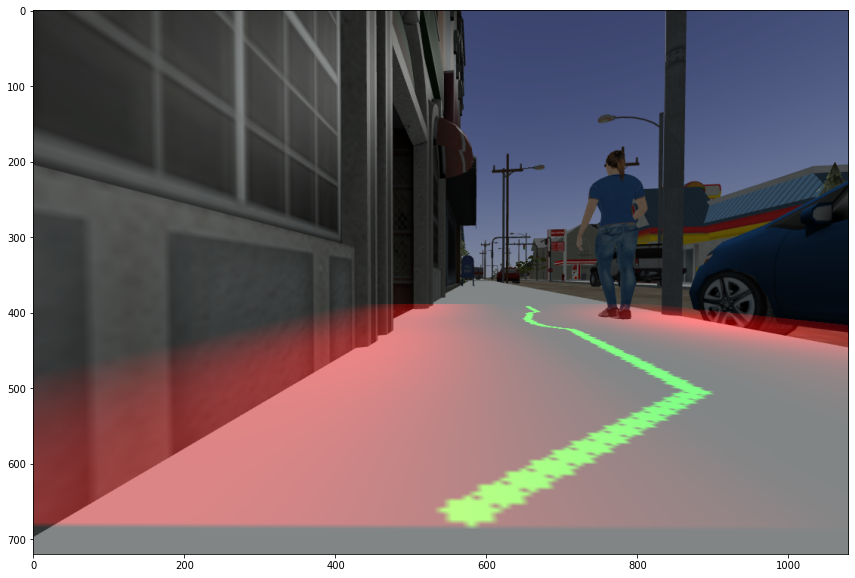

0.5927209854125977


In [2]:
import time
nav = NavigationSystem()
img = cv2.imread("./data/75.png")
# img = cv2.imread("./data/195.png")
h_orig,w_orig,_ = img.shape


img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
start = time.time()
nav.path_planning(img)
end = time.time()
print(end-start)
